## Point Patterns

At https://martinfleischmann.net/sds/micro/point_patterns/exercise.html

### Read the data from the web

In [ ]:
import pandas as pd

url = "http://data.insideairbnb.com/czech-republic/prague/prague/2024-12-22/data/listings.csv.gz"
df = pd.read_csv(url, compression='gzip')
df.head()

### Create a dataframe

And project the data into EPSG:5514

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Project to S-JTSK / Krovak East North EPSG:5514
gdf = gdf.to_crs("EPSG:5514")

gdf.head()

### Create a hexbin visualisation

In [ ]:
import matplotlib.pyplot as plt

# Create hexbin plot
plt.figure(figsize=(12, 8))
plt.hexbin(gdf.geometry.x, gdf.geometry.y, gridsize=50, cmap='YlOrRd')
plt.colorbar(label='Number')
plt.title('Hexbin visualization of Airbnb')
plt.xlabel('X coordinate (meters)')
plt.ylabel('Y coordinate (meters)')
plt.show()

### Create a KDE Visualisation

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.kdeplot(data=df, x='longitude', y='latitude', cmap='viridis', fill=True)
plt.title('Kernel Density Estimation of Airbnb Listings in Prague')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Q. What can you read from the hexbin you cannot from the KDE and vice versa?

The hexbin visualisation has low resolution and the detail around the edges is lost, compared to the KDE. However the KDE does a better job of revealing the spatial distribution around the edges. The Hexbin is good for a quick summary of the intensity in the centre. 

### show the mean median and mean weighted of price from gdf

In [ ]:
# convert to float
gdf['price'] = gdf['price'].str.replace('$', '').str.replace(',', '').astype(float)

# Calculate statistics
mean_price = gdf['price'].mean()
median_price = gdf['price'].median()

# Calculate weighted mean reviews as weight
weighted_mean = (gdf['price'] * gdf['number_of_reviews']).sum() / gdf['number_of_reviews'].sum()

print(f"Mean price: ${mean_price:.2f}")
print(f"Median price: ${median_price:.2f}")
print(f"Review-weighted mean price: ${weighted_mean:.2f}")

### A.

The weighted mean using number of reviews as weights gives us a better sense of the typical price that guests actually pay, since it gives more weight to frequently booked properties. The regular mean is significantly higher than both the median and weighted mean, suggesting there are some very expensive outliers pulling up the average.


In [ ]:
# Add projected coordinates as columns
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# Drop the lat/lon columns
gdf = gdf.drop(['latitude', 'longitude'], axis=1)

# First few rows
gdf[['x', 'y']].head()

In [ ]:
!pip install pointpats

### Examine centrography

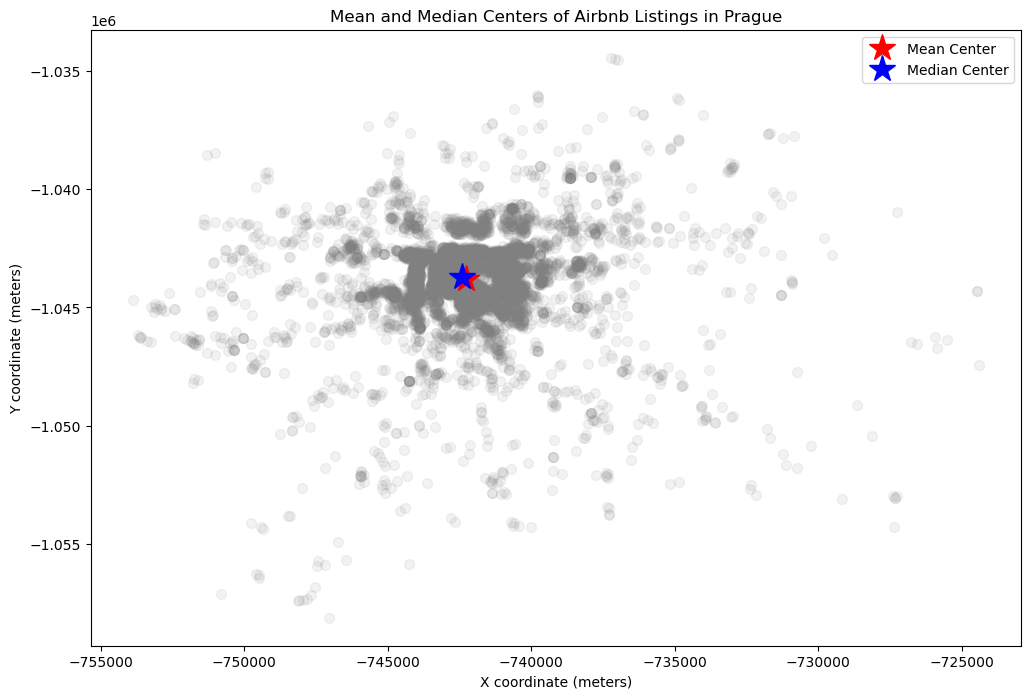

Mean center coordinates: [ -742261.78419697 -1043806.92669243]
Median center coordinates: [ -742392.2747162 -1043722.1219183]


In [15]:
import pointpats
import numpy as np

# Extract coordinates into a numpy array
coords = np.column_stack((gdf.geometry.x, gdf.geometry.y))

# Calculate mean center
mean_center = pointpats.centrography.mean_center(coords)

# Calculate median center manually
median_center = np.median(coords, axis=0)

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.1, c='gray', s=50)
plt.plot(mean_center[0], mean_center[1], 'r*', markersize=20, label='Mean Center')
plt.plot(median_center[0], median_center[1], 'b*', markersize=20, label='Median Center')
plt.legend()
plt.title('Mean and Median Centers of Airbnb Listings in Prague')
plt.xlabel('X coordinate (meters)')
plt.ylabel('Y coordinate (meters)')
plt.show()

print(f"Mean center coordinates: {mean_center}")
print(f"Median center coordinates: {median_center}")

### Examine the Q Stat

<Figure size 1200x800 with 0 Axes>

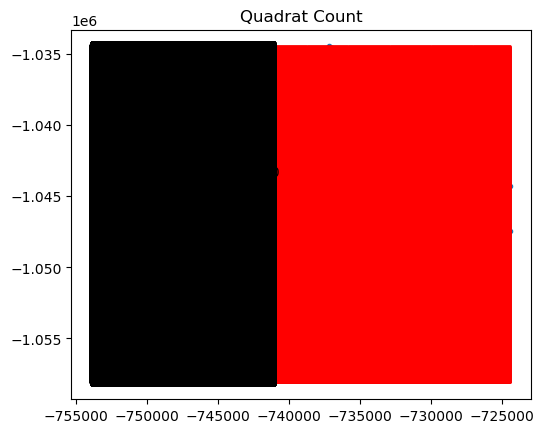

In [16]:
import pointpats

# Create quadrat count using QStatistic
qstat = pointpats.QStatistic(coords, shape="rectangle", nx=2500, ny=2500)

# Plot the results
plt.figure(figsize=(12, 8))
qstat.plot()
plt.title('Quadrat Statistics of Airbnb Listings (2500x2500 grid)')
plt.xlabel('X coordinate (meters)')
plt.ylabel('Y coordinate (meters)')
plt.show()

# Print chi-square test results
print("\nChi-square test results:")
print(f"Statistic: {qstat.chi2}")
print(f"p-value: {qstat.chi2_pvalue}")

### Calculate the G and F from Ripleys

In [ ]:
from pointpats import g_test, f_test

# Calculate G-function test
g = g_test(coords)

# Calculate F-function test
f = f_test(coords)

# Plot both functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# G-function plot
ax1.plot(g.r, g.g, label='Empirical G(r)')
ax1.plot(g.r, g.gtheo, '--', label='CSR')
ax1.fill_between(g.r, g.g_lb, g.g_ub, alpha=0.5, label='Confidence envelope')
ax1.set_title("G-function (Nearest Neighbor)")
ax1.set_xlabel("Distance")
ax1.set_ylabel("G(r)")
ax1.legend()

# F-function plot
ax2.plot(f.r, f.f, label='Empirical F(r)')
ax2.plot(f.r, f.ftheo, '--', label='CSR')
ax2.fill_between(f.r, f.f_lb, f.f_ub, alpha=0.5, label='Confidence envelope')
ax2.set_title("F-function (Empty Space)")
ax2.set_xlabel("Distance")
ax2.set_ylabel("F(r)")
ax2.legend()

plt.tight_layout()
plt.show()

print("\nG-function test results:")
print(f"Test statistic: {g.g_max}")
print(f"p-value: {g.p_value}")

print("\nF-function test results:")
print(f"Test statistic: {f.f_max}")
print(f"p-value: {f.p_value}")